In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

MASS = 1.0
HBAR = 1.0
AUTOEV = 27.2114
AUTONM = 0.05291772108

# qGrid: 0.0 to 5.0; NGRID = 1024; 
# rGrid: 0.0 to 0.02*TWOPI / (NGRID * dq)    --> 0.0 to 25.7108; NGRID = 1024; 
NQGRID = 2048
qGrid = np.linspace(0.0, 10.0, NQGRID)
dq = (10.0-0.0)/NQGRID

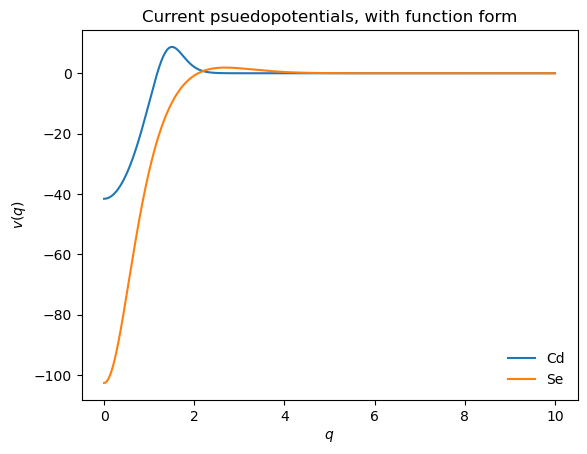

In [2]:
def pot_func(x, params): 
    pot = (params[0]*(x*x - params[1]) / (params[2] * np.exp(params[3]*x*x) - 1.0))
    return pot

def plotBandStruct(bandStruct_array, marker_array, label_array): 
    fig, axs = plt.subplots(1,1, figsize=(7,7))
    for bandStructIndex in range(len(bandStruct_array)): 
        numBands = len(bandStruct_array[bandStructIndex][0])
        numKpts = len(bandStruct_array[bandStructIndex])
        for i in range(numBands): 
            if i==0: 
                axs.plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i], marker_array[bandStructIndex], label=label_array[bandStructIndex])
            else: 
                axs.plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i], marker_array[bandStructIndex])
    axs.legend(frameon=False)
    plt.show()
    return
    
CdParams = np.array([-31.4518, 1.3890, -0.0502, 1.6603, 0.0586])
SeParams = np.array([8.4921, 4.3513, 1.3600, 0.3227, 0.1746])
SParams = np.array([7.6697, 4.5192, 1.3456, 0.3035, 0.2087])
PP_order = np.array(["Cd", "Se", "S"])
totalParams = np.vstack((CdParams, SeParams, SParams))

plt.plot(qGrid, pot_func(qGrid, CdParams), label="Cd")
plt.plot(qGrid, pot_func(qGrid, SeParams), label="Se")
plt.title("Current psuedopotentials, with function form")
plt.xlabel(r"$q$")
plt.ylabel(r"$v(q)$")
plt.legend(frameon=False)
plt.show()

CdPP = pot_func(qGrid, CdParams)
SePP = pot_func(qGrid, SeParams)
totalPP = np.concatenate((CdPP, SePP))

375.1361680361416


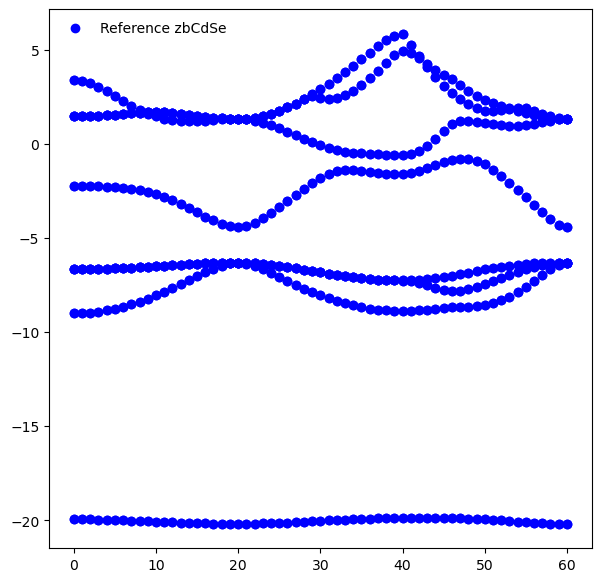

In [3]:
nSystem = 1

# read system
scale = 11.4485278
unitCellVector1 = np.array([0.0, 0.5, 0.5]) * scale
unitCellVector2 = np.array([0.5, 0.0, 0.5]) * scale
unitCellVector3 = np.array([0.5, 0.5, 0.0]) * scale
unitCellVectors = np.vstack((unitCellVector1, unitCellVector2, unitCellVector3))
cellVolume = np.dot(unitCellVector1, np.cross(unitCellVector2, unitCellVector3))
print(cellVolume)

prefactor = 2 * np.pi / cellVolume
gVector1 = prefactor * np.cross(unitCellVectors[1], unitCellVectors[2])
gVector2 = prefactor * np.cross(unitCellVectors[2], unitCellVectors[0])
gVector3 = prefactor * np.cross(unitCellVectors[0], unitCellVectors[1])
gVectors = np.vstack((gVector1, gVector2, gVector3))

nAtoms = 2
atomTypes = np.array(["Cd", "Se"])
atomPos = np.array([[0.125, 0.125, 0.125],
                    [-0.125, -0.125, -0.125]])
atomPos = atomPos @ unitCellVectors

# read kPoints
kpt_zbCdSe = np.loadtxt("inputs/kpoints_0.par")
kpt_zbCdSe = kpt_zbCdSe @ gVectors
nkpt = len(kpt_zbCdSe)
# Gamma = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float64)

# read band strcture
Eref_zbCdSe = np.loadtxt("inputs/expBandStruct_0.par")[:, 1:]
plotBandStruct([Eref_zbCdSe], ["bo"], ["Reference zbCdSe"])

maxKE = 10

nBands = 16

In [4]:
def basis(maxKE, scale, unitCellVectors, gVectors, cellVolume): 
    minGMag = min(np.linalg.norm(gVectors[0]), np.linalg.norm(gVectors[1]), np.linalg.norm(gVectors[2]))
    numMaxBasisVectors = int(np.sqrt(2*maxKE) / minGMag)
    # print(numMaxBasisVectors)

    k = np.tile(np.arange(-numMaxBasisVectors, numMaxBasisVectors+1), (2*numMaxBasisVectors+1)**2)
    j = np.tile(np.repeat(np.arange(-numMaxBasisVectors, numMaxBasisVectors+1),(2*numMaxBasisVectors+1)), (2*numMaxBasisVectors+1))
    i = np.repeat(np.arange(-numMaxBasisVectors, numMaxBasisVectors+1),(2*numMaxBasisVectors+1)**2)
    allGrid = np.transpose(np.vstack((i, j, k)))
    transform = np.transpose(gVectors)
    allBasisSet = allGrid @ transform
    # print(len(allBasisSet))
    # print(allBasisSet)

    row_norms = np.linalg.norm(allBasisSet, axis=1)
    condition = (HBAR*0.5*row_norms**2 / MASS < maxKE)
    indices = np.where(condition)[0]
    basisSet = allBasisSet[indices]
    # print(len(basisSet))
    # print(basisSet)
    
    row_norms = np.linalg.norm(basisSet, axis=1)
    sorting_indices = np.lexsort((basisSet[:, 2], basisSet[:, 1], basisSet[:, 0], row_norms))    
    sorted_basisSet = basisSet[sorting_indices]
    # print(len(sorted_basisSet))
    # print(sorted_basisSet)
    
    return sorted_basisSet

basisStates = basis(maxKE, scale, unitCellVectors, gVectors, cellVolume)
# print(basisStates)
# print(basisStates[:20])

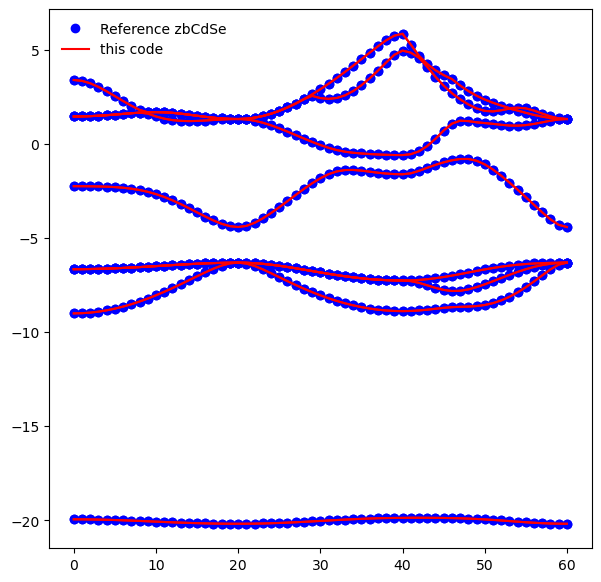

Are all the numbers within the threshold of 1e-11? 
True


In [5]:
# construct hamiltonian at Gamma. Quicker through vectorization. 
def calcHamiltonianMatrix_PPFunc(basisStates, kVector, nAtoms, cellVolume):
    n = len(basisStates)
    HMatrix = np.zeros((n, n), dtype=complex)

    # Kinetic energy
    for i in range(n): 
        HMatrix[i,i] += HBAR**2 / (2*MASS) * (np.linalg.norm(basisStates[i] + kVector))**2
        
    # Local potential
    gDiff = np.stack([basisStates] * len(basisStates), axis=1) - np.tile(basisStates, (len(basisStates),1,1))
    for k in range(nAtoms): 
        gDiffDotTau = np.sum(gDiff * atomPos[k], axis=2)
        structFact = 1/cellVolume * (np.cos(gDiffDotTau) + 1j*np.sin(gDiffDotTau))

        thisAtomIndex = np.where(atomTypes[k]==PP_order)[0]
        if len(thisAtomIndex)!=1: 
            raise ValueError("Type of atoms in PP. ")
        thisAtomIndex = thisAtomIndex[0]
        atomFF = pot_func(np.linalg.norm(gDiff, axis=2), totalParams[thisAtomIndex])
        
        '''
        qIndex = (np.linalg.norm(gDiff, axis=2) / dq).astype(int)
        # atomFF = totalPP[qIndex + NQGRID * thisAtomIndex]
        atomFF = (totalPP[qIndex + NQGRID * thisAtomIndex]+totalPP[qIndex+1 + NQGRID * thisAtomIndex])/2
        '''
        
        HMatrix += atomFF * structFact
    return HMatrix

def calcBandStruct(basisStates, nkpt, kpts_coord, nAtoms, cellVolume, nBands): 
    bandStruct = np.zeros((nkpt, nBands), dtype=float)
    for kpt_index in range(nkpt): 
        HamiltonianMatrixAtKpt = calcHamiltonianMatrix_PPFunc(basisStates, kpts_coord[kpt_index], nAtoms, cellVolume)

        # diagonalize the hamiltonian
        energies = np.linalg.eigvalsh(HamiltonianMatrixAtKpt)
        energies *= AUTOEV
        
        # 2-fold degeneracy due to spin
        energies = energies.repeat(2)[:nBands]
    
        bandStruct[kpt_index] = energies

    return bandStruct
    

newBandStruct = calcBandStruct(basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
plotBandStruct([Eref_zbCdSe, newBandStruct], ["bo", "r-"], ["Reference zbCdSe", "this code"])

print("Are all the numbers within the threshold of 1e-11? ")
print(np.all(newBandStruct - Eref_zbCdSe)<1e-11)
